In [1]:
import re, sys
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# get bond film table
# df = pd.read_html('https://en.wikipedia.org/wiki/List_of_James_Bond_films')

In [2]:
# import stop words
stopwords = STOPWORDS

# the following check and clean srt specific lines
def is_time_stamp(l):
    if l[:2].isnumeric() and l[2] == ':':
        return True
    return False


def has_letters(line):
    if re.search('[a-zA-Z]', line):
        return True
    return False


def has_no_text(line):
    l = line.strip()
    if not len(l):
        return True
    if l.isnumeric():
        return True
    if is_time_stamp(l):
        return True
    if l[0] == '(' and l[-1] == ')':
        return True
    if not has_letters(line):
        return True
    return False


def is_lowercase_letter_or_comma(letter):
    if letter.isalpha() and letter.lower() == letter:
        return True
    if letter == ',':
        return True
    return False

# removes non-text lines, combines broken lines
def clean_up(lines):
    # add 'text' to list so the dataframe has a column name
    new_lines = ['text\n']
    for line in lines[1:]:
        if has_no_text(line):
            continue
        elif len(new_lines) and is_lowercase_letter_or_comma(line[0]):
            #combine with previous line
            new_lines[-1] = new_lines[-1].strip() + ' ' + line
        else:
            #append line
            new_lines.append(line)
    return new_lines


# convert srt to txt file in directory, stores txt as variable
def srt_to_txt(srt_file, encoding):
    with open(srt_file, encoding=encoding, errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
    new_file_name = srt_file[:-4] + '.txt'
    with open(new_file_name, 'w') as f:
        # add 'text' to list so the dataframe has a column name
        f.write('text\n')
        for line in new_lines:
            f.write(line)
    # for variable use in the main function and not to write to disk again
    return new_lines

# puts .txt file into a dataframe, returns df
def to_df(text):
    df = pd.read_csv(pd.compat.StringIO("\n".join(text)), sep=";")
    #remove puncutation
    df['text'] = df['text'].str.replace('[^\w\s]', '')
    return df

# counts the number of words and and creates dictionary for use in make_cloud()
def get_words(df, col='text'):
    new_results_list = []

    # count words for word cloud
    results = Counter()
    words_to_results = df[col].str.lower().str.split().apply(results.update)

    # sort words
    new_results = results.most_common()

    # ADD WORDS YOU DON'T WANT HERE, if they come up
    random_stopwords = ['rt', '&amp;', '-', '.', '→', '<i>',
                        'v', '&', '|', '-&gt;', 'totn',
                        "it's", '^cs', "b's", '^ji', '^bb',
                        '--&gt;', 'font', 'color808080banefont',
                        'color808080waynefont', 'color808080',
                        '1font'] #for example

    # clean results list
    for i in range(len(new_results)):
        if new_results[i][0] in stopwords:
            continue
        if new_results[i][0] in random_stopwords:
            continue
        else:
            new_results_list.append(new_results[i])

    # send to wordcloud
    clean_cloud = dict(new_results_list)
    return clean_cloud


def make_cloud(text, image, bac_colour='white', cont_color='white', 
col_map='autumn'):
    """
    text: dictionary key:value pair, count:word, sorted by highest
    image: .jpg file, solid fill greater than 1024x768,
            typically an inverse of a logo
    bac_colour: sets image background colour, will fill behind words,
                white is cleanest.
    cont_color: colours the contour around the image,
                set to 'white' by default.
    col_map: matplotlib gradient, search
             https://matplotlib.org/users/colormaps.html
             for available options
    """
    # import image
    logo_mask = np.array(Image.open(f'{image}'))
    file_name = image[:-4] + '.png'

    # generate a wordcloud to image
    stopwords = STOPWORDS
    wc = WordCloud(background_color=bac_colour,
                   max_words=420, mask=logo_mask,
                   contour_width=0, contour_color=cont_color,
                   colormap=col_map)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(10, 10), dpi=1000)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
#     plt.savefig(file_name)
    plt.show();

In [3]:
# the following check and clean srt specific lines
def is_time_stamp(l):
    if l[:2].isnumeric() and l[2] == ':':
        return True
    return False

def get_start_time(line):
    time = line.split()[0]
    print(time)
    if time[:2].isnumeric() and time[2] == ':':
        print(time)


def has_letters(line):
    if re.search('[a-zA-Z]', line):
        return True
    return False


def has_no_text(line):
    l = line.strip()
    if not len(l):
        return True
    if l.isnumeric():
        return True
    if is_time_stamp(l):
        return True
    if l[0] == '(' and l[-1] == ')':
        return True
    if not has_letters(line):
        return True
    return False


def is_lowercase_letter_or_comma(letter):
    if letter.isalpha() and letter.lower() == letter:
        return True
    if letter == ',':
        return True
    return False

# removes non-text lines, combines broken lines
def clean_up(lines):
    # add 'text' to list so the dataframe has a column name
    new_lines = []
    time_stamps = []
    temp_lst = []
    for line in lines[1:]:
        if has_no_text(line):
            if line[:2].isnumeric() and line[2] == ':':
                time_stamps.append(line[:8])
                continue
            continue
        elif len(new_lines) and is_lowercase_letter_or_comma(line[0]):
            #combine with previous line
            new_lines[-1] = new_lines[-1].strip() + ' ' + line
        else:
            #append line
            new_lines.append(line)
    for text, time in zip(new_lines, time_stamps):
        temp_line = [time, text.replace('\n', '').replace('-', '')]
        temp_lst.append(temp_line)
    return temp_lst


# convert srt to txt file from directory returns dict
def srt_to_txt(srt_file, encoding):
    with open(srt_file, encoding=encoding, errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
    new_file_name = srt_file[:-4] + '.txt'
    return new_lines

# puts .txt file into a dataframe, returns df
def to_df(text):
    df = pd.read_csv(pd.compat.StringIO("\n".join(text)), sep=";")
    #remove puncutation
    df['text'] = df['text'].str.replace('[^\w\s]', '')
    return df

df = pd.read_csv('Raw_Bond_Tables.csv')

df_titles = df[0:1].values
df_main = pd.DataFrame(df[2:-2])
df_main.columns = df_titles[0]

# clean columns
df_main['Title'] = df_main.Title.apply(lambda x: x.replace('[N]', ''))
df_main.drop(df_main.index[4], inplace=True)

# Sort by decade
df_main['Decade'] = df_main['Year'].apply(lambda x: x[2]+'0')

df_main.reset_index(drop=True, inplace=True)

bond_srts = ['GoldenEye', 'Goldfinger']
bond_srts = [i for i in df_main.Title]
bond_srts[0] = 'Dr'
bond_dict = dict()

for srt in bond_srts:
    srt_test = f'Subtitles/{srt}.en.srt'
    encoding = 'utf-8' 
    temp = srt_to_txt(srt_test, encoding)[1:] #ignore first advertisement 
    bond_dict[srt] = temp

bond_dict['Dr. No'] = bond_dict["Dr"] 
del bond_dict["Dr"]

bond_dfs = []
for film in bond_dict:    
    temp_df = pd.DataFrame(bond_dict[film], columns=['Time', film])
    
    to_keep = []
    for i, row in enumerate(temp_df[temp_df.columns[1]]):
        if row.startswith('<i>(') or row.startswith('<f'):
            continue
        if row.startswith('<i>'):
            temp_df[temp_df.columns[1]].iloc[i] = row.replace('<i>', '')
        else:
            temp_df[temp_df.columns[1]].iloc[i] = row.replace('.', '').replace(',', '').replace('?', '').replace('!', '').replace('"', '')
            to_keep.append(i)
    
    temp_df.iloc[to_keep].reset_index(drop=True).to_csv(f'Subtitles/{film}_subs.csv')
    
    bond_dfs.append(temp_df.iloc[to_keep].reset_index(drop=True))
bond_dfs[0].head(5)

,Time,From Russia with Love
0,00:02:20,Agh
1,00:02:40,Exactly 1 minute 52 seconds
2,00:05:58,That's excellent
3,00:06:02,Check
4,00:06:07,Knight takes bishop


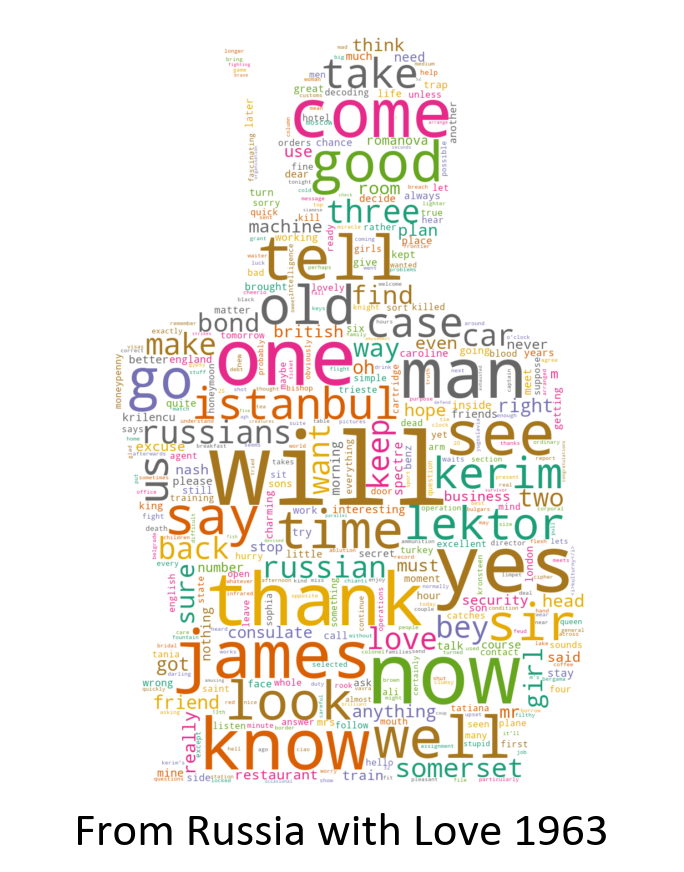

In [5]:
def image_map(film_title):
    """Returns image path for each film"""
    actor = df_main['Bond actor'][df_main.Title == film_title].values[0]
    
    if actor == 'Sean Connery':
        return 'Masks/connery.png'
    elif actor == 'George Lazenby':
        return 'Masks/lazenby_mask1.jpg'
    elif actor == 'Roger Moore':
        return 'Masks/moore_mask2.jpg'
    elif actor == 'Timothy Dalton':
        return 'Masks/dalton_mask1.jpg'
    elif actor == 'Pierce Brosnan':
        return 'Masks/bronsan_mask2.jpg'
    elif actor == 'Daniel Craig':
        return 'Masks/craig_mask2.jpg'
  
    
def make_cloud(text, image, title, year, bac_colour='white', cont_color='white', col_map='autumn', words=420):
    """
    text: dictionary key:value pair, count:word, sorted by highest
    image: .jpg file, solid fill greater than 1024x768,
            typically an inverse of a logo
    bac_colour: sets image background colour, will fill behind words,
                white is cleanest.
    cont_color: colours the contour around the image,
                set to 'white' by default.
    col_map: matplotlib gradient, search
             https://matplotlib.org/users/colormaps.html
             for available options
    """
    # import image
    logo_mask = np.array(Image.open(f'{image}'))

    # generate a wordcloud to image
    stopwords = STOPWORDS
    wc = WordCloud(background_color=bac_colour,
                   max_words=words, mask=logo_mask,
                   contour_width=0, contour_color=cont_color,
                   colormap=col_map)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(5, 5), dpi=2000)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'WCs/{title}_wc.png')
    
    title = title + ' ' + year
    plt.title(title, y=-0.1, x=0.42, fontsize=17, fontname="Calibri")
    plt.show();
    
for title, text in zip(list(bond_dict.keys()), bond_dfs):
    # Assign text cloud and select correct mask
    text = get_words(text, col=text.columns[1])  
    image = image_map(title)
    year = df_main['Year'][df_main.Title == title].values[0]
    
    make_cloud(text, image, title, year, col_map='Dark2_r')
    break

In [9]:
for title, text in zip(list(bond_dict.keys()), bond_dfs):
    # Assign text cloud and select correct mask
    temp_text = text[title].values
temp_text

array(['Enter the code',
       "And Reddington is suddenly looking for a mysterious blood doctor who's doing cuttingedge research into gene sequencing",
       " You're Raymond Reddington", " And you're in my debt",
       'The plan is already in motion', 'Men are coming Elizabeth',
       'Men who kill every living thing who gets in their way',
       'Tell Harold and then you get out of that hospital',
       'Advertise your product or brand here contact wwwOpenSubtitlesorg today',
       'Okay cameras up', 'When you engage you have a',
       '4minute window for extraction',
       'Colonel Wright ordered a dialysis',
       "Can't let you in without a scan", "Okay Viktor someone's coming",
       'Can I help you', 'Four minutes and counting',
       'Is it true The DNA test', "You're not Kirk's daughter",
       'Tell your team to expect a full military assault',
       'What are you talking about',
       'I just got off the phone with Reddington',
       "He has reason to believ